# Power Outage Severity Prediction

# Summary of Findings


### Introduction
In this project we are looking at a dataset containing information about all major power outages occuring in the US between January 2012 and July 2016. Each row represents a power outage and the columns contain attributes to the power outage. 

We are interested in predicting the severity of a major power outage. The target variable we chose to use is the column CUSTOMERS.AFFECTED, which is the number of customers affected by the major power outage event. We chose this variable as a predictor of the severity since the severity of an outage can be measured by the number of customers affected. We want the number of customers affected to be as small as possible for any major power outage. The evaluation metric we are using is R^2, the coefficient of determination. We chose to use R^2 because it allows us to test the accuracy of our model as well as compare the difference between the training and testing data. We want the R^2 of the training and testing data to be as close together as possible. If the R^2 of the training data is really high, but the test data low, then we know that we have overfit our model. 

### Baseline Model
For our baseline model, we train a linear regression model using 7 features (5 quantitative, 2 nominal, 0 ordinal) to predict the number of customers affected by an outage. 

Nominal features: YEAR, POSTAL.CODE, NERC.REGION, CLIMATE.REGION
Quantitative features: DEMAND.LOSS.MW, OUTAGE.DURATION, POPDEN_RURAL
We did not use any ordinal features. 

In building our model, we apply SimpleImputer to the quantitative features and apply SimpleImputer and OneHotEncoder to the nominal features. We train our model using a train-test split of 90%/10% and score both the training and test data in order to get our R^2 evaluation metric. For our training data we got 0.54 and for our test data we got -1.46. This model performance is not very good. Not only is our training data inaccurate, but the difference in accuracy between the training and test data is high. This is not an ideal model, so we will look to improve this in our final model.

### Final Model
For the final model, we switched to random forest regression model and set the max depth to 8 after searching for the best model using GridSearchCV. We chose to use a max depth of 8 because the model improved little or not at all after 8. We also applied StandardScaler to the quantitative columns to use their zscores so that all values are between the range of 0 and 1. We do this so that all of the quantitative data uses the same center scale. We also use PCA after one hot encoding our categorical variables in order to get rid of extra noise by dropping the correlated features. 

After doing a train-test split of 90%/10% we get our R^2 evaluation metric for both the training and test data. For the training data we scored 0.88 and scored 0.37 for the test data. Although the final model improved the R^2 value of the training and test data, the difference in values is still really high. Thus the model is still being overfit. 

### Fairness Evaluation
Since we used a regression model, we are going to assess the fairness of our model using R^2 because this is a measure of accuracy for regression. We perform a permutation test at a signifiance level of 0.05 with the test statistic given by R^2. 

H0: The distributions of the R^2 evaluation metric is the same for long and short duration power outages. 

H1: The distributions of the R^2 evaluation metric is different for long and short duration power outages. 

After running the permutation test we get a p-value of 0.48. Thus we fail to reject the null hypothesis. 

# Code

In [362]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures
from helper_fns import *
%load_ext autoreload
%autoreload 2
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [363]:
# load in the data
data = pd.read_excel('outage.xlsx', skiprows = 5, header=[0,1])
#clean the outage dataset using the data cleaning in project 3 through a helper function
clean_data = clean_outage_data(data)

### Baseline Model

In [364]:
pred_df = clean_data[['YEAR','CAUSE.CATEGORY.DETAIL','DEMAND.LOSS.MW', 
                      'POSTAL.CODE', 'NERC.REGION', 'CLIMATE.REGION', 
                      'CLIMATE.CATEGORY', 'CAUSE.CATEGORY', 'OUTAGE.DURATION', 
                      'CUSTOMERS.AFFECTED', 'TOTAL.PRICE', 'POPDEN_RURAL']]
pred_df = pred_df.loc[pred_df['CAUSE.CATEGORY'] == 'severe weather']
#need to handle nulls better in actual project 
pred_df = pred_df.dropna()

In [365]:
x_cols = pred_df[['DEMAND.LOSS.MW', 'OUTAGE.DURATION', 'CAUSE.CATEGORY.DETAIL', 
                  'YEAR', 'POSTAL.CODE', 'NERC.REGION', 'CLIMATE.REGION', 'POPDEN_RURAL']]
y = pred_df['CUSTOMERS.AFFECTED']
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=.1, random_state=10)



In [366]:
num_vars = ['DEMAND.LOSS.MW', 'OUTAGE.DURATION', 'POPDEN_RURAL']
cat_vars = ['CAUSE.CATEGORY.DETAIL', 'YEAR', 'POSTAL.CODE', 'NERC.REGION', 'CLIMATE.REGION']
cat_trans = Pipeline([
    ('simp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')), 
])

preproc = ColumnTransformer(transformers=[
    ('num trans', SimpleImputer(strategy='constant', fill_value=0), num_vars), 
    ('cat trans', cat_trans, cat_vars)])
pl = Pipeline(steps=[('preprocessor', preproc), ('lin regress', LinearRegression())])

In [367]:
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num trans',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['DEMAND.LOSS.MW',
                                                   'OUTAGE.DURATION',
                                                   'POPDEN_RURAL']),
                                                 ('cat trans',
                                                  Pipeline(steps=[('simp',
                                                                   SimpleImputer(fill_value='NULL',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
          

In [368]:
train_rsquared = pl.score(X_train, y_train)
test_rsquared = pl.score(X_test, y_test)
train_rmse = np.sqrt(np.mean(pl.predict(X_train) - y_train))
test_rmse = np.sqrt(np.mean(pl.predict(X_test) - y_test))
print("R^2 for training data: ", train_rsquared)
print("R^2 for test data: ", test_rsquared)

R^2 for training data:  0.5435658602006856
R^2 for test data:  -1.4627665653773323


<ipython-input-368-557a49fbd79a>:3: RuntimeWarning: invalid value encountered in sqrt
  train_rmse = np.sqrt(np.mean(pl.predict(X_train) - y_train))
<ipython-input-368-557a49fbd79a>:4: RuntimeWarning: invalid value encountered in sqrt
  test_rmse = np.sqrt(np.mean(pl.predict(X_test) - y_test))


### Final Model

In [369]:
pred_df = clean_data[['MONTH','YEAR','CAUSE.CATEGORY.DETAIL','DEMAND.LOSS.MW', 'POSTAL.CODE', 'NERC.REGION', 
                      'CLIMATE.REGION', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY', 'OUTAGE.DURATION', 
                      'CUSTOMERS.AFFECTED', 'TOTAL.PRICE', 'POPDEN_RURAL']]
pred_df = pred_df.loc[pred_df['CAUSE.CATEGORY'] == 'severe weather']
#need to handle nulls better in actual project 
pred_df = pred_df.dropna()

In [370]:
x_cols = pred_df[['DEMAND.LOSS.MW', 'OUTAGE.DURATION', 'CAUSE.CATEGORY.DETAIL', 
                  'YEAR', 'POSTAL.CODE', 'NERC.REGION', 'CLIMATE.REGION', 'POPDEN_RURAL']]
y = pred_df['CUSTOMERS.AFFECTED']
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=.1, random_state=10)

In [371]:
num_vars = ['DEMAND.LOSS.MW', 'OUTAGE.DURATION', 'POPDEN_RURAL']
cat_vars = ['CAUSE.CATEGORY.DETAIL', 'YEAR', 'POSTAL.CODE', 'NERC.REGION', 'CLIMATE.REGION']
cat_trans = Pipeline([
    ('simp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')), 
    ('pca', PCA(svd_solver='full', n_components=0.8))
])

preproc = ColumnTransformer(transformers=[('num trans', SimpleImputer(strategy='constant', fill_value=0), num_vars), 
                                          ('cat trans', cat_trans, cat_vars)])
pl = Pipeline(steps=[('preprocessor', preproc), ('reg', RandomForestRegressor())])

In [372]:
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num trans',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['DEMAND.LOSS.MW',
                                                   'OUTAGE.DURATION',
                                                   'POPDEN_RURAL']),
                                                 ('cat trans',
                                                  Pipeline(steps=[('simp',
                                                                   SimpleImputer(fill_value='NULL',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
          

In [373]:
pl.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'reg', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num trans', 'preprocessor__cat trans', 'preprocessor__num trans__add_indicator', 'preprocessor__num trans__copy', 'preprocessor__num trans__fill_value', 'preprocessor__num trans__missing_values', 'preprocessor__num trans__strategy', 'preprocessor__num trans__verbose', 'preprocessor__cat trans__memory', 'preprocessor__cat trans__steps', 'preprocessor__cat trans__verbose', 'preprocessor__cat trans__simp', 'preprocessor__cat trans__ohe', 'preprocessor__cat trans__pca', 'preprocessor__cat trans__simp__add_indicator', 'preprocessor__cat trans__simp__copy', 'preprocessor__cat trans__simp__fill_value', 'preprocessor__cat trans__simp__missing_values', 'preprocessor__cat trans__simp__strategy', 'preprocessor__cat trans__simp__verbose', 'prepro

In [374]:
params = {
    'reg__max_depth': np.arange(2,30,2)
}
grids = GridSearchCV(pl, param_grid=params, cv=3, return_train_score=True)
grids.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num '
                                                                         'trans',
                                                                         SimpleImputer(fill_value=0,
                                                                                       strategy='constant'),
                                                                         ['DEMAND.LOSS.MW',
                                                                          'OUTAGE.DURATION',
                                                                          'POPDEN_RURAL']),
                                                                        ('cat '
                                                                         'trans',
                                                                         Pipeline(steps=[('simp',
                

In [375]:
grids.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_reg__max_depth', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [376]:
grids.param_grid

{'reg__max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])}

In [377]:
index = grids.param_grid['reg__max_depth']
test = grids.cv_results_['mean_test_score']
train = grids.cv_results_['mean_train_score']

<AxesSubplot:>

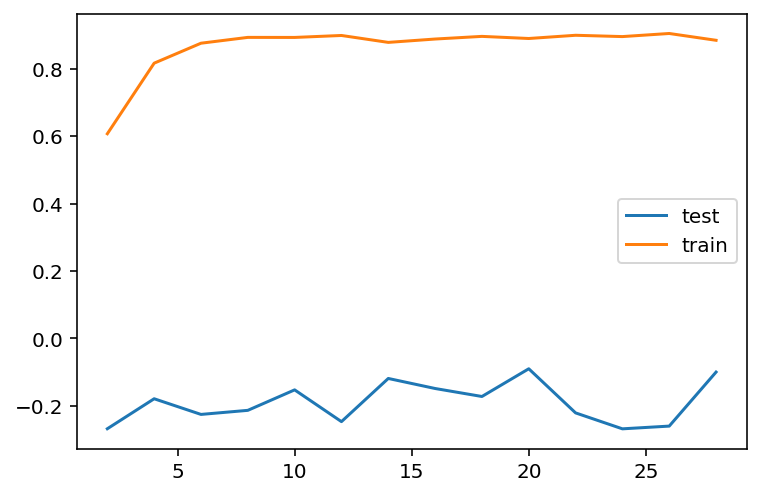

In [378]:
pd.DataFrame({'test': test, 'train': train}, index=index).plot()

In [379]:
num_vars = ['DEMAND.LOSS.MW', 'OUTAGE.DURATION', 'POPDEN_RURAL']
cat_vars = ['CAUSE.CATEGORY.DETAIL', 'YEAR', 'POSTAL.CODE', 'NERC.REGION', 'CLIMATE.REGION']
cat_trans = Pipeline([
    ('simp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('pca', PCA(svd_solver='full', n_components=0.8))
])

num_trans = Pipeline([
    ('simp', SimpleImputer(strategy='constant', fill_value=0)), 
    ('StdScale', StandardScaler())
])

preproc = ColumnTransformer(transformers=[('num trans', num_trans, num_vars), 
                                          ('cat trans', cat_trans, cat_vars)])
pl = Pipeline(steps=[('preprocessor', preproc), ('reg', RandomForestRegressor(max_depth=8))])

In [380]:
pl.fit(X_train, y_train)
train_rsquared = pl.score(X_train, y_train)
test_rsquared = pl.score(X_test, y_test)
print("R^2 for training data: ", train_rsquared)
print("R^2 for test data: ", test_rsquared)

R^2 for training data:  0.884675517453927
R^2 for test data:  0.3686689500874374


In [381]:
preds = pl.predict(X_test)

### Fairness Evaluation

In [382]:
# long is outage duration greater than 5000
results = X_test
results['long_outage'] = (results['OUTAGE.DURATION'] <= 5000).replace({True:'long', False:'short'})
results['prediction'] = preds
results['tag'] = y_test
results.groupby('long_outage').prediction.mean().to_frame()

<ipython-input-382-bf221e27bd23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['long_outage'] = (results['OUTAGE.DURATION'] <= 5000).replace({True:'long', False:'short'})
<ipython-input-382-bf221e27bd23>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['prediction'] = preds
<ipython-input-382-bf221e27bd23>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,prediction
long_outage,
long,222456.112011
short,303267.454438


In [383]:
obs = results.groupby('long_outage').apply(lambda x: metrics.r2_score(x.tag, x.prediction)).diff().iloc[-1]
metrs = []
for _ in range(100):
    results = results.reset_index(drop=True)
   
    sampled = results[['long_outage', 'prediction', 'tag']].assign(long_outage=results['long_outage']
                                                                   .sample(frac=1.0, replace=False)
                                                                   .reset_index(drop=True))

    s = sampled.groupby('long_outage').apply(lambda x: metrics.r2_score(x.tag, x.prediction)).diff().iloc[-1]
    
    metrs.append(s)

In [384]:
p_value = pd.Series(metrs <= obs).mean()
p_value

0.15